# ENSEMBLE solutions

This notebook ensembles many submissions, taking into account RNA structure constraints

## EDA of existing solutions

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances

# === STRUCTURAL VALIDATION ===
C1p_C1p_min = 3.0
C1p_C1p_max = 6.0
angle_tolerance_deg = 30

def compute_bond_lengths(coords):
    return np.linalg.norm(coords[1:] - coords[:-1], axis=1)

def compute_bond_angles(coords):
    v1 = coords[1:-1] - coords[:-2]
    v2 = coords[2:] - coords[1:-1]
    dot_prod = np.sum(v1 * v2, axis=1)
    norms = np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1)
    cos_theta = np.clip(dot_prod / norms, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def validate_structure(coords):
    bond_lengths = compute_bond_lengths(coords)
    bond_angles = compute_bond_angles(coords)
    length_violations = np.sum((bond_lengths < C1p_C1p_min) | (bond_lengths > C1p_C1p_max))
    angle_violations = np.sum((bond_angles < (180 - angle_tolerance_deg)) | 
                              (bond_angles > (180 + angle_tolerance_deg)))
    return {
        "num_length_violations": int(length_violations),
        "num_angle_violations": int(angle_violations),
        "mean_bond_length": float(np.mean(bond_lengths)),
        "mean_bond_angle": float(np.mean(bond_angles)),
    }

def validate_all_structures_named(submissions, names):
    results = []
    for sub_idx, df in enumerate(submissions):
        for i in range(5):
            coords = df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values
            metrics = validate_structure(coords)
            metrics["submission_name"] = names[sub_idx]
            metrics["structure_i"] = i
            results.append(metrics)
    return results

# === LOAD SUBMISSIONS ===
folder = "/kaggle/input/stanford-rna-folding-best-submissions"
files = [f for f in os.listdir(folder) if f.endswith(".csv")]

def extract_score(filename):
    try:
        return float(filename.rstrip(".csv").split("_")[-1])
    except ValueError:
        return 0.0

submissions, scores, names = [], [], []
for f in files:
    df = pd.read_csv(os.path.join(folder, f))
    submissions.append(df)
    scores.append(extract_score(f))
    name = f.replace("submission ", "").replace(".csv", "")
    names.append(name)

# Validate
validation_named = pd.DataFrame(validate_all_structures_named(submissions, names))
validation_named.to_csv("structure_validation_metrics_named.csv", index=False)
print("✅ structure_validation_metrics_named.csv saved")


✅ structure_validation_metrics_named.csv saved


/tmp/ipykernel_13/2771189813.py:19: RuntimeWarning: invalid value encountered in divide
  cos_theta = np.clip(dot_prod / norms, -1.0, 1.0)
/tmp/ipykernel_13/2771189813.py:20: RuntimeWarning: invalid value encountered in arccos
  return np.degrees(np.arccos(cos_theta))
/tmp/ipykernel_13/2771189813.py:26: RuntimeWarning: invalid value encountered in less
  angle_violations = np.sum((bond_angles < (180 - angle_tolerance_deg)) |
/tmp/ipykernel_13/2771189813.py:27: RuntimeWarning: invalid value encountered in greater
  (bond_angles > (180 + angle_tolerance_deg)))
/tmp/ipykernel_13/2771189813.py:19: RuntimeWarning: invalid value encountered in divide
  cos_theta = np.clip(dot_prod / norms, -1.0, 1.0)
/tmp/ipykernel_13/2771189813.py:20: RuntimeWarning: invalid value encountered in arccos
  return np.degrees(np.arccos(cos_theta))
/tmp/ipykernel_13/2771189813.py:26: RuntimeWarning: invalid value encountered in less
  angle_violations = np.sum((bond_angles < (180 - angle_tolerance_deg)) |
/tmp/i

In [2]:
validation_named

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,num_length_violations,num_angle_violations,mean_bond_length,mean_bond_angle,submission_name,structure_i
0,270,2512,5.804355,32.959439,nufold_0349,0
1,295,2511,5.801505,33.360581,nufold_0349,1
2,295,2512,5.789091,33.367442,nufold_0349,2
3,348,2512,5.798274,33.415560,nufold_0349,3
4,348,2512,5.798274,33.415560,nufold_0349,4
5,1303,2503,3.702451,40.616697,rna3dstructure_256,0
6,573,2475,5.848633,43.274293,rna3dstructure_256,1
7,587,2482,5.726924,42.905639,rna3dstructure_256,2
8,1068,2370,4.887798,60.869787,rna3dstructure_256,3
9,1160,2358,5.228521,62.561111,rna3dstructure_256,4


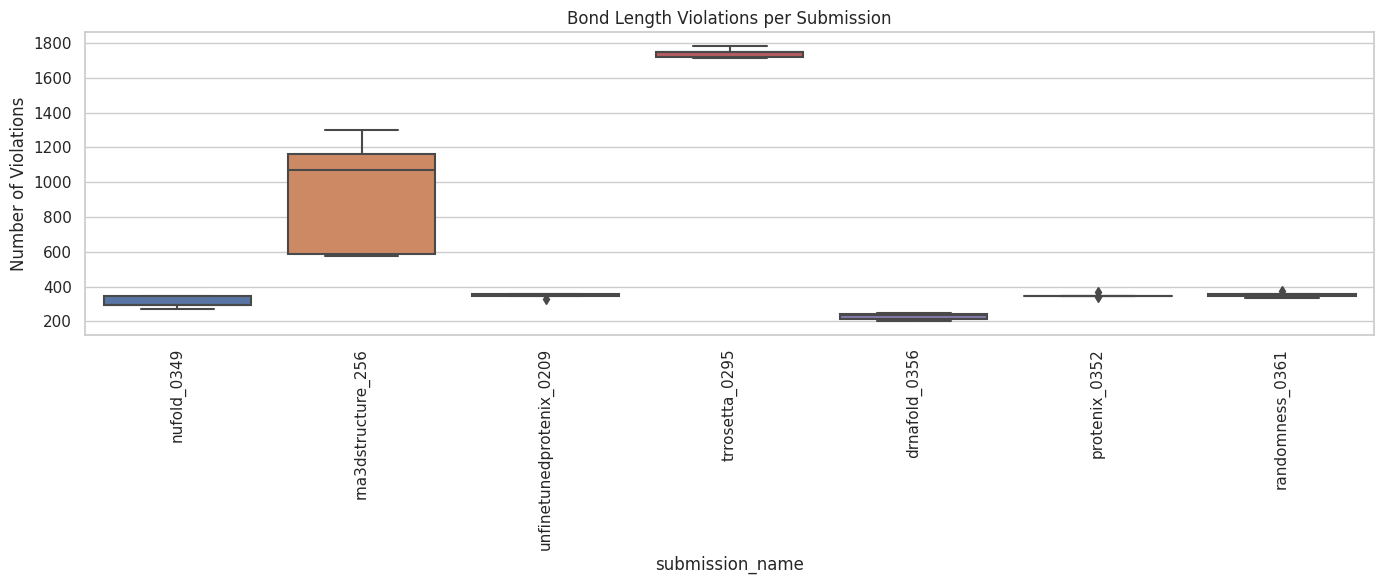

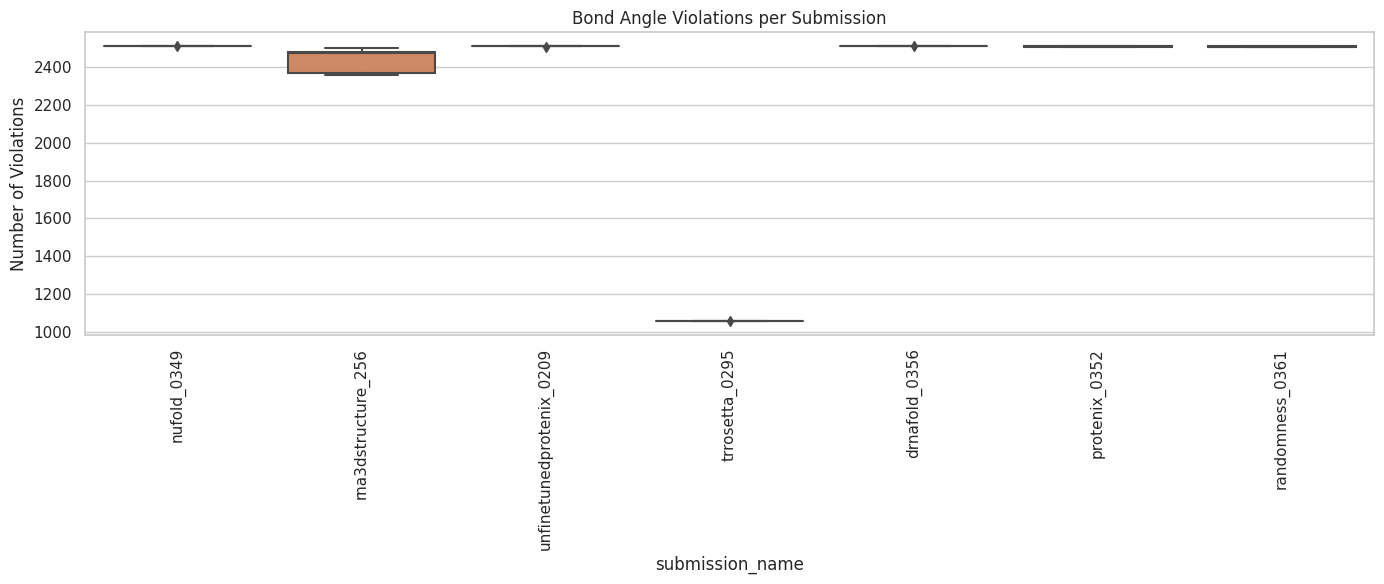

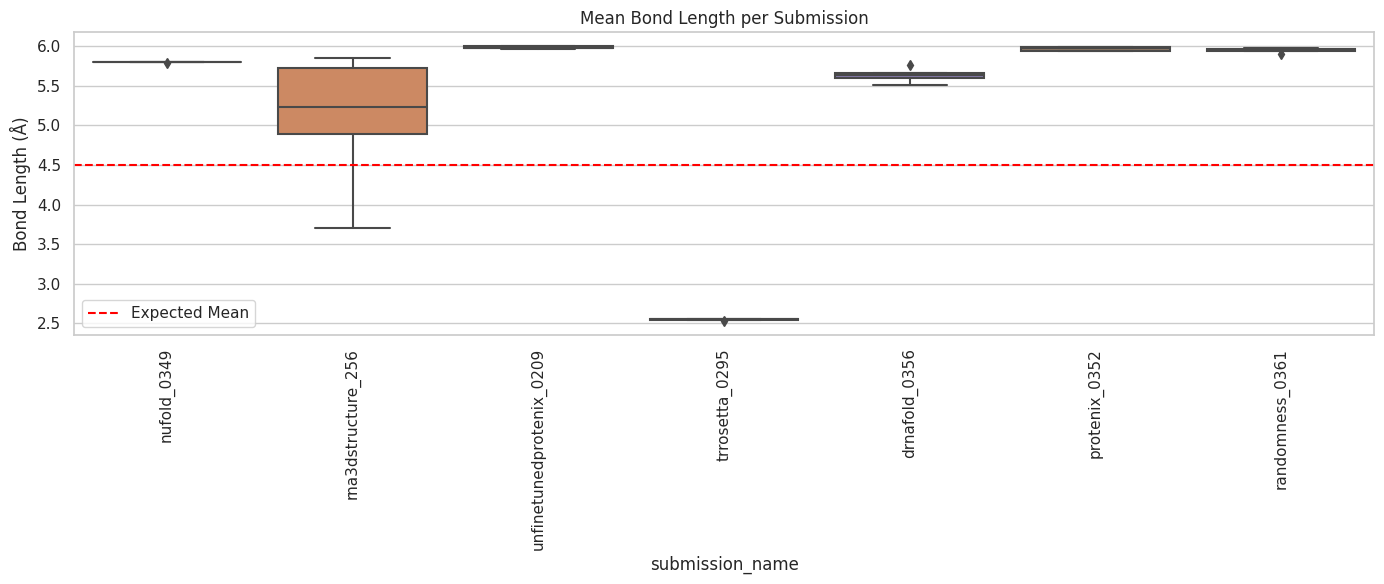

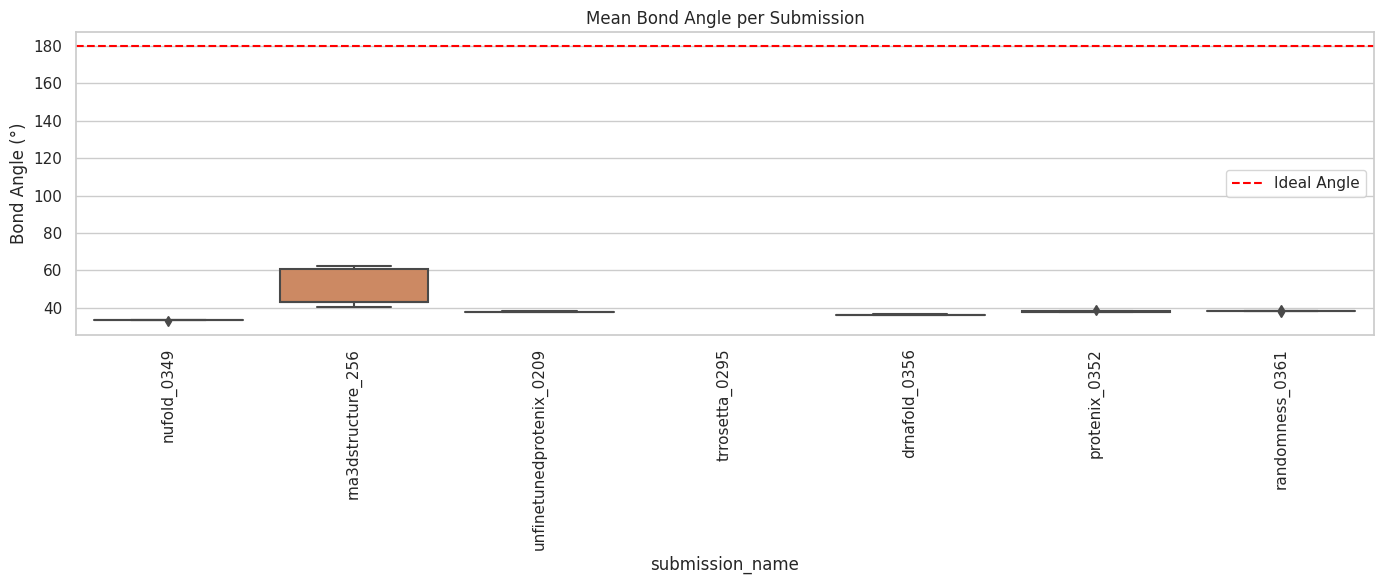

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your DataFrame is loaded
validation_named = pd.read_csv("structure_validation_metrics_named.csv")

# Plot configuration
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.boxplot(data=validation_named, x="submission_name", y="num_length_violations")
plt.title("Bond Length Violations per Submission")
plt.xticks(rotation=90)
plt.ylabel("Number of Violations")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=validation_named, x="submission_name", y="num_angle_violations")
plt.title("Bond Angle Violations per Submission")
plt.xticks(rotation=90)
plt.ylabel("Number of Violations")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=validation_named, x="submission_name", y="mean_bond_length")
plt.title("Mean Bond Length per Submission")
plt.axhline(4.5, color='red', linestyle='--', label='Expected Mean')
plt.xticks(rotation=90)
plt.ylabel("Bond Length (Å)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=validation_named, x="submission_name", y="mean_bond_angle")
plt.title("Mean Bond Angle per Submission")
plt.axhline(180, color='red', linestyle='--', label='Ideal Angle')
plt.xticks(rotation=90)
plt.ylabel("Bond Angle (°)")
plt.legend()
plt.tight_layout()
plt.show()


## ENSEMBLING

In [4]:
def ensemble_weighted_average(submissions, scores):
    meta_cols = ['ID', 'resname', 'resid']
    num_structures = 5
    weights = np.array(scores)
    weights = weights / np.sum(weights)
    
    pred_stack = []
    for df in submissions:
        pred_coords = []
        for i in range(num_structures):
            pred_coords.append(df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values)
        pred_coords = np.stack(pred_coords, axis=1)  # (n_residues, 5, 3)
        pred_stack.append(pred_coords)
    pred_stack = np.stack(pred_stack, axis=0)  # (n_subs, n_residues, 5, 3)
    
    weighted_avg = np.tensordot(weights, pred_stack, axes=([0], [0]))  # (n_residues, 5, 3)

    output = submissions[0][meta_cols].copy()
    for i in range(num_structures):
        output[f"x_{i+1}"] = weighted_avg[:, i, 0]
        output[f"y_{i+1}"] = weighted_avg[:, i, 1]
        output[f"z_{i+1}"] = weighted_avg[:, i, 2]
    return output


def ensemble_best5_diverse(submissions, scores):
    meta_cols = ['ID', 'resname', 'resid']
    all_structures = []
    structure_sources = []
    
    for s_idx, df in enumerate(submissions):
        for i in range(5):
            coords = df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values
            all_structures.append(coords)
            structure_sources.append((s_idx, i))
    
    flat_structures = [s.reshape(-1) for s in all_structures]
    D = pairwise_distances(flat_structures, metric='euclidean')
    
    best_submission_idx = np.argmax(scores)
    first_structure_idx = structure_sources.index((best_submission_idx, 0))
    selected_idx = [first_structure_idx]

    while len(selected_idx) < 5:
        remaining = list(set(range(len(all_structures))) - set(selected_idx))
        next_idx = max(remaining, key=lambda i: min(D[i, j] for j in selected_idx))
        selected_idx.append(next_idx)
    
    selected = [all_structures[i] for i in selected_idx]
    output = submissions[0][meta_cols].copy()
    for i in range(5):
        output[f"x_{i+1}"] = selected[i][:, 0]
        output[f"y_{i+1}"] = selected[i][:, 1]
        output[f"z_{i+1}"] = selected[i][:, 2]
    return output


# === Run and Save Ensembles ===
weighted_df = ensemble_weighted_average(submissions, scores)
diverse_df = ensemble_best5_diverse(submissions, scores)

weighted_df.to_csv("submission_weighted_average.csv", index=False)
diverse_df.to_csv("submission_best5_diverse.csv", index=False)
print("✅ Saved: submission_weighted_average.csv and submission_best5_diverse.csv")


✅ Saved: submission_weighted_average.csv and submission_best5_diverse.csv


In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import numpy as np

def select_structures_by_validation(validation_df, all_structures, structure_sources, names, keep_percentile=0.2):
    validation_df = validation_df.copy()
    validation_df["total_violations"] = (
        validation_df["num_length_violations"] + validation_df["num_angle_violations"]
    )
    threshold = np.percentile(validation_df["total_violations"], keep_percentile * 100)

    selected_indices = []
    for i, row in validation_df.iterrows():
        if row["total_violations"] <= threshold:
            try:
                idx = structure_sources.index((names.index(row["submission_name"]), row["structure_i"]))
                selected_indices.append(idx)
            except ValueError:
                continue
    print(f"✅ Selected {len(selected_indices)} structures below {keep_percentile*100:.0f}th percentile threshold")
    return selected_indices


def ensemble_diverse_filtered_clustered(submissions, scores, validation_df, names, num_clusters=5):
    meta_cols = ['ID', 'resname', 'resid']
    all_structures = []
    structure_sources = []

    for s_idx, df in enumerate(submissions):
        for i in range(5):
            coords = df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values
            all_structures.append(coords)
            structure_sources.append((s_idx, i))

    flat_structures = [s.reshape(-1) for s in all_structures]
    D = pairwise_distances(flat_structures, metric='euclidean')

    # Step 1: filter
    valid_indices = select_structures_by_validation(validation_df, all_structures, structure_sources, names)
    if len(valid_indices) < 5:
        print("⚠️ Not enough valid structures. Falling back to top diverse ensemble.")
        return ensemble_best5_diverse(submissions, scores)

    filtered_structures = [flat_structures[i] for i in valid_indices]

    # Step 2: cluster
    clustering = AgglomerativeClustering(n_clusters=min(num_clusters, len(filtered_structures)), linkage='ward')
    labels = clustering.fit_predict(filtered_structures)

    # Step 3: one per cluster, prefer high score
    selected_idx = []
    for cluster_id in range(max(labels) + 1):
        members = [valid_indices[i] for i, lbl in enumerate(labels) if lbl == cluster_id]
        best = max(members, key=lambda i: scores[structure_sources[i][0]])
        selected_idx.append(best)
        if len(selected_idx) == 5:
            break

    if len(selected_idx) < 5:
        others = list(set(valid_indices) - set(selected_idx))
        others_sorted = sorted(others, key=lambda i: scores[structure_sources[i][0]], reverse=True)
        selected_idx += others_sorted[:5 - len(selected_idx)]

    selected = [all_structures[i] for i in selected_idx]
    output = submissions[0][meta_cols].copy()
    for i in range(5):
        output[f"x_{i+1}"] = selected[i][:, 0]
        output[f"y_{i+1}"] = selected[i][:, 1]
        output[f"z_{i+1}"] = selected[i][:, 2]
    return output

def ensemble_blend_with_top_original(submissions, scores, blend_ratio=0.5):
    meta_cols = ['ID', 'resname', 'resid']
    num_structures = 5
    weights = np.array(scores) / np.sum(scores)

    pred_stack = []
    for df in submissions:
        coords = []
        for i in range(num_structures):
            coords.append(df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values)
        pred_stack.append(np.stack(coords, axis=1))
    pred_stack = np.stack(pred_stack, axis=0)
    weighted_avg = np.tensordot(weights, pred_stack, axes=([0], [0]))

    top_idx = np.argmax(scores)
    top_coords = []
    for i in range(num_structures):
        top_coords.append(submissions[top_idx][[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values)
    top_coords = np.stack(top_coords, axis=1)

    blended = blend_ratio * weighted_avg + (1 - blend_ratio) * top_coords

    output = submissions[0][meta_cols].copy()
    for i in range(num_structures):
        output[f"x_{i+1}"] = blended[:, i, 0]
        output[f"y_{i+1}"] = blended[:, i, 1]
        output[f"z_{i+1}"] = blended[:, i, 2]
    return output

# === Generate both advanced ensembles ===
clustered_filtered_df = ensemble_diverse_filtered_clustered(submissions, scores, validation_named, names)
blended_df = ensemble_blend_with_top_original(submissions, scores)

clustered_filtered_df.to_csv("submission_filtered_clustered.csv", index=False)
blended_df.to_csv("submission_blend_weighted_top.csv", index=False)
print("✅ Saved: submission_filtered_clustered.csv and submission_blend_weighted_top.csv")


✅ Selected 7 structures below 20th percentile threshold
✅ Saved: submission_filtered_clustered.csv and submission_blend_weighted_top.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


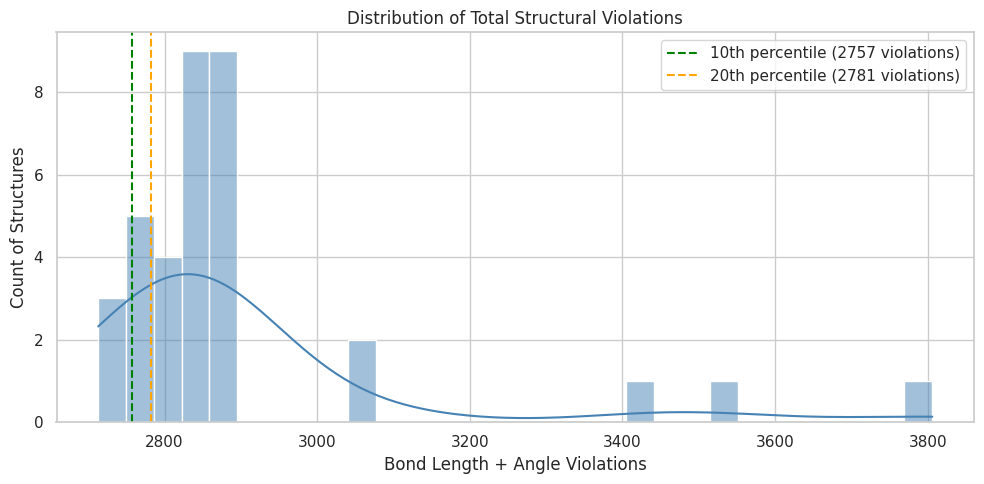

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load if not already in memory
validation_named = pd.read_csv("structure_validation_metrics_named.csv")

# Add total violations column
validation_named["total_violations"] = (
    validation_named["num_length_violations"] + validation_named["num_angle_violations"]
)

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(validation_named["total_violations"], bins=30, kde=True, color="steelblue")
plt.title("Distribution of Total Structural Violations")
plt.xlabel("Bond Length + Angle Violations")
plt.ylabel("Count of Structures")

# Add percentile lines
p10 = np.percentile(validation_named["total_violations"], 10)
p20 = np.percentile(validation_named["total_violations"], 20)
plt.axvline(p10, color="green", linestyle="--", label=f"10th percentile ({int(p10)} violations)")
plt.axvline(p20, color="orange", linestyle="--", label=f"20th percentile ({int(p20)} violations)")

plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import os

def save_submission_in_folder(df, folder_name):
    os.makedirs(folder_name, exist_ok=True)
    df.to_csv(os.path.join(folder_name, "submission.csv"), index=False)
    print(f"✅ Saved: {folder_name}/submission.csv")

# Save each ensemble into its own folder
save_submission_in_folder(clustered_filtered_df, "submission_filtered_clustered")
save_submission_in_folder(blended_df, "submission_blend_weighted_top")
save_submission_in_folder(weighted_df, "submission_weighted_average")
save_submission_in_folder(diverse_df, "submission_best5_diverse")


✅ Saved: submission_filtered_clustered/submission.csv
✅ Saved: submission_blend_weighted_top/submission.csv
✅ Saved: submission_weighted_average/submission.csv
✅ Saved: submission_best5_diverse/submission.csv


In [8]:
def save_submission_versions_and_link_final(final_choice="filtered_clustered"):
    import shutil
    
    # Save backup versions with clear names
    clustered_filtered_df.to_csv("submission_filtered_clustered.csv", index=False)
    blended_df.to_csv("submission_blend_weighted_top.csv", index=False)
    weighted_df.to_csv("submission_weighted_average.csv", index=False)
    diverse_df.to_csv("submission_best5_diverse.csv", index=False)

    # Copy the selected file to submission.csv
    name_map = {
        "filtered_clustered": "submission_filtered_clustered.csv",
        "blend_weighted_top": "submission_blend_weighted_top.csv",
        "weighted_average": "submission_weighted_average.csv",
        "best5_diverse": "submission_best5_diverse.csv"
    }

    final_file = name_map[final_choice]
    shutil.copy(final_file, "submission.csv")
    print(f"✅ submission.csv set to: {final_file}")
save_submission_versions_and_link_final("weighted_average")

✅ submission.csv set to: submission_weighted_average.csv
